In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from analysis_utils import get_run_data, process_run_data, add_significance_marks, aggregate_metrics, METRIC_NAMES

In [2]:
data, config = get_run_data("eli-carrami/Cprt-Paper-Exp-0")
out = []
best_basis = "biochem/val_kingdom_f1"
use_last = True
for d, c in zip(data, config):
    llm = c['model']['value']['language_model']
    if 'gpt' in llm:
        h = d.iloc[-1].copy()
    elif use_last:
        d = d[d.epoch == 0]
        h = d.iloc[-1].copy()
    else:
        h = d.iloc[d[best_basis].idxmax()].copy()
    h['protein_layer_to_use'] = c['model']['value']['protein_layer_to_use']
    h['protein_layer_to_use'] = -1 if h['protein_layer_to_use'] == 12 else h['protein_layer_to_use']
    h['llm'] = llm
    h['strategy'] = c['model']['value']['multimodal_strategy']
    h['seed'] = c['seed']['value']
    out.append(h)

In [3]:
layer_order = ["wte", -1]
var = 'protein_layer_to_use'

fltr = [('strategy', "soft-prompt"), ('llm', "microsoft/phi-2")]
ordering = (var, layer_order)
df = process_run_data(out, fltr, ordering)

In [4]:
df

,biochem/val_is_real_f1,biochem/val_is_enzyme_hard_f1,biochem/val_kingdom_f1,biochem/val_localization_f1,biochem/val_cofactor,biochem/val_is_fake_f1,biochem/val_mw_error,metrics/val_perplexity,metrics/val_rouge1_fmeasure,metrics/val_rouge1_precision,...,metrics/val_rougeL_recall,biochem/val_in_membrane_f1,biochem/val_in_nucleus_f1,biochem/val_in_mitochondria_f1,epoch,protein_layer_to_use,llm,strategy,seed,avg_binary_loc_f1
0,0.336420,0.714976,0.017371,0.438840,0.157303,0.339672,0.030888,2.234674,0.694559,0.742295,...,0.638906,0.182472,0.143680,0.111918,0.0,wte,microsoft/phi-2,soft-prompt,0,0.146023
1,0.475436,0.712899,0.164033,0.447664,0.273913,0.334212,0.035065,2.241564,0.631487,0.665109,...,0.583132,0.189345,0.122917,0.041002,0.0,wte,microsoft/phi-2,soft-prompt,7,0.117755
2,0.497237,0.725844,0.282414,0.470707,0.177489,0.398295,0.024969,2.244588,0.671488,0.695347,...,0.632515,0.201805,0.354759,0.040310,0.0,wte,microsoft/phi-2,soft-prompt,42,0.198958
16,0.977570,0.904725,0.835265,0.708241,0.565543,0.323959,0.027409,1.904260,0.665851,0.710419,...,0.614095,0.228500,0.615079,0.253119,0.0,-1,microsoft/phi-2,soft-prompt,0,0.365566
17,0.990100,0.896040,0.784014,0.750832,0.608696,0.588005,0.035503,1.917535,0.666465,0.711823,...,0.614069,0.314479,0.709888,0.270831,0.0,-1,microsoft/phi-2,soft-prompt,7,0.431733
3,0.991903,0.882552,0.785815,0.666606,0.558442,0.884888,0.026024,1.946568,0.621353,0.614211,...,0.615599,0.276175,0.619288,0.191364,0.0,-1,microsoft/phi-2,soft-prompt,42,0.362276


In [4]:
metrics_names = {k:v for k, v in METRIC_NAMES.items() if 'rouge' not in k}
agg_df = aggregate_metrics(df, group_by=var)
agg_df = agg_df[[col for col in metrics_names]]

for col, name in metrics_names.items():
    agg_df[name] = round(agg_df[(col, 'mean')], 2).astype(str) + " (" + round(agg_df[(col, 'std')], 2).astype(str) + ")"
    agg_df.drop([(col, 'mean'), (col, 'std')], axis=1, inplace=True)

agg_df.to_clipboard()
agg_df

/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(['mean', 'std'])


,is_real F1,is_enzyme F1,kingdom F1,localization F1,cofactor Recall,binary localization\naverage F1,is_fake F1,MW MALE,perplexity,in_membrane F1,in_nucleus F1,in_mitochondria F1
,,,,,,,,,,,,
protein_layer_to_use,,,,,,,,,,,,
wte,0.44 (0.09),0.72 (0.01),0.15 (0.13),0.45 (0.02),0.2 (0.06),0.15 (0.04),0.36 (0.04),0.03 (0.01),2.24 (0.01),0.19 (0.01),0.21 (0.13),0.06 (0.04)
-1,0.99 (0.01),0.89 (0.01),0.8 (0.03),0.71 (0.04),0.58 (0.03),0.39 (0.04),0.6 (0.28),0.03 (0.01),1.92 (0.02),0.27 (0.04),0.65 (0.05),0.24 (0.04)


In [39]:
metrics = {
    'biochem/val_mw_error': 'mw\nMALE',
    'biochem/val_cofactor': 'exact \ncofactor',
    'biochem/val_is_enzyme_hard_f1': 'is_enzyme\nF1',
    'biochem/val_localization_f1': 'localization\nF1',
    'avg_binary_loc_f1': 'binary Q\nmean F1',
    'metrics/val_perplexity': 'perplexity',
    'metrics/val_rouge1_fmeasure': 'ROUGE1\nScore',
    'metrics/val_rouge1_precision': 'ROUGE1\nPrecision',
    'metrics/val_rouge1_recall': 'ROUGE1\nRecall',
    'metrics/val_rougeL_fmeasure': 'ROUGEL\nScore',
    'metrics/val_rougeL_precision': 'ROUGEL\nPrecision',
    'metrics/val_rougeL_recall': 'ROUGEL\nRecall'
}
ylims = {k: [0, 1] for k in metrics}
modes = {k: "min" if any([h in k for h in ["perplexity", "error"]]) else "max" for k in metrics}

/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])


wte -1 biochem/val_mw_error 0.3433395794986603 0.4665969870229949
wte -1 biochem/val_cofactor 0.0016289997053466722 -17.476774369794427


/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])


wte -1 biochem/val_is_enzyme_hard_f1 0.0016268841645607115 -17.488189464820415
wte -1 biochem/val_localization_f1 0.0074701882965043315 -8.089281817002481


/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])


wte -1 avg_binary_loc_f1 0.016997381705958953 -5.2844054507890625
wte -1 metrics/val_perplexity 0.00048612218128024734 32.04759349327091


/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])


wte -1 metrics/val_rouge1_fmeasure 0.6874933371417852 0.5720538982885521
wte -1 metrics/val_rouge1_precision 0.6935113177747056 0.5935910864710624


/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])


wte -1 metrics/val_rouge1_recall 0.6438045238978274 0.42468442584260535
wte -1 metrics/val_rougeL_fmeasure 0.6409507263389855 0.415520990712368


/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])
/Users/elicarrami/PycharmProjects/cprt/cprt/analysis/analysis_utils.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_by).agg(["mean", "std"])


wte -1 metrics/val_rougeL_precision 0.6604196624297682 0.4790615669302257
wte -1 metrics/val_rougeL_recall 0.5722495144650976 0.2065199250126836


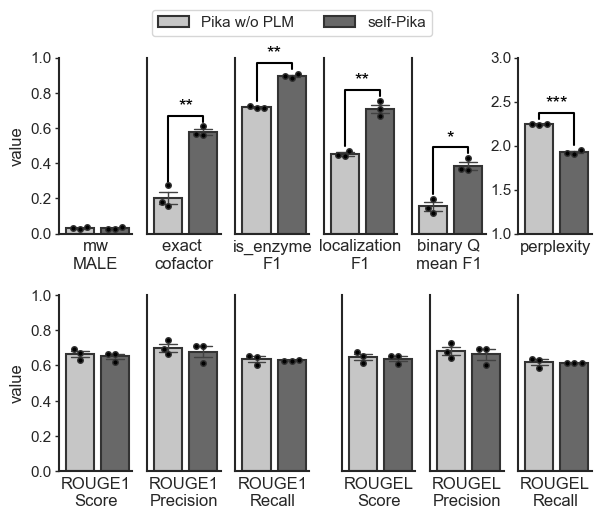

In [43]:
import warnings
import matplotlib as mpl
from scipy.stats import ttest_rel


mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8
warnings.filterwarnings('once')

sns.set(style="white")
label_size=9

plot_configs = {
    "palette": sns.color_palette("Greys", len(layer_order)),
    "errorbar": 'se', "err_kws": {'linewidth': 1}, "capsize":0.5, "edgecolor":'0.2', "lw":1.5
}

df_melted = df.melt(id_vars=var, value_vars=df.columns.drop(var))

fig, axes = plt.subplots(2, 6, figsize=(6, 5))

ylims.update({'metrics/val_perplexity': [1, 3]})

for i, (m, ax) in enumerate(zip(metrics, axes.flatten())):
    _df = df_melted[df_melted['variable'] == m]
    sns.barplot(x=_df[var], y=_df['value'], hue=_df[var], ax=ax, **plot_configs)
    sns.swarmplot(x=_df[var], y=_df['value'], s=4, edgecolor='0.2', fc='black', linewidth=1, ax=ax)

    ax.set_xlabel(metrics[m])
    ax.set_xticks([])

    if i % 6 !=0:
        ax.set_ylabel('')

    if i not in [0, 5, 6]:
        ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_linewidth(1.5)


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(-0.6, None)
    ax.set_ylim(ylims[m])

    ax.tick_params(axis='y', which='major', pad=2)
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_tick_params(length=3, width=1)
    ax.get_legend().remove()

    s1, s2 = "wte", -1
    l, t = ax.get_ylim()
    offset = (t - l) / 30

    agg_df = aggregate_metrics(df, var)
    first_layer_data = df[df[var] == s1][[m, "seed"]]
    last_layer_data = df[df[var] == s2][[m, "seed"]]

    if len(first_layer_data) == len(last_layer_data):
        col = "black"
        assert (first_layer_data["seed"].values == last_layer_data["seed"].values).all()
        stat, p_value = ttest_rel(
            first_layer_data[m],
            last_layer_data[m],
            alternative="greater" if modes[m] == "min" else "less" if modes[m] == "max" else "two-sided",
        )
    else:
        print("ERROR")
    print(s1, s2, m, p_value, stat)
    # Add asterisks if significant
    if p_value < 0.05:
        cnt = 3 if p_value < 0.001 else 2 if p_value < 0.01 else 1
        x1, x2 = 0, 1
        y1 = agg_df[m].iloc[0].sum() + offset * 0.9
        y2 = agg_df[m].iloc[-1].sum() + offset * 0.9
        top = max(y1, y2) + offset
        # Draw lines from the first and last bars to the asterisk
        ax.plot([x1, x1, x2, x2], [y1, top, top, y2], color=col, lw=1.5)
        # Draw the asterisk
        ax.text((x1 + x2) / 2, top, cnt * "*", ha="center", va="bottom", fontsize=14, color=col)




handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, ["Pika w/o PLM", "self-Pika"], loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
for i, ax in enumerate(axes.flatten()):
    pos = ax.get_position()
    if i in [5, 9, 10, 11]:
        ax.set_position([pos.x0 + 0.03, pos.y0, pos.width, pos.height])

# plt.show()
plt.savefig("stat_bars.png")